In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps, ImageFilter, ImageEnhance
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs
import cv2
import tensorflow as tf
import os
import pandas as pd

2024-02-08 11:59:56.323931: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-08 11:59:58.227190: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-08 12:00:02.071007: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 12:00:02.071070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 12:00:02.778183: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10
pcv.params.debug = "None"

In [3]:
img = np.array(Image.open("../leaves/images/Grape_spot/image (1014).JPG", "r"))

In [4]:
colospace = pcv.visualize.colorspaces(rgb_img=img)

In [5]:
gray_img = pcv.rgb2gray_cmyk(rgb_img=img, channel='y')

In [6]:
channels = cv2.split(img)

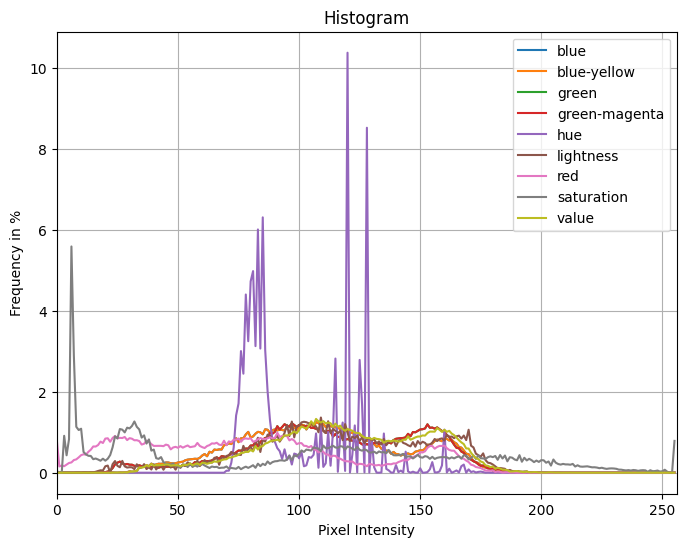

In [7]:
def histogram_with_colors(img, color_spaces):
    plt.figure(figsize=(8, 6))

    for color_space in color_spaces:
        if color_space == "blue":
            channel = img[1:, :, 0]
        # elif color_space == "blue-yellow":
        #     blue_yellow = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:, :, 2]
        #     channel = cv2.subtract(img[:, :, 2], blue_yellow)
        elif color_space == "green":
            channel = img[1:, :, 1]
        # elif color_space == "green-magenta":
        #     green_magenta = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:, :, 1]
        #     channel = cv2.subtract(img[:, :, 1], green_magenta)
        elif color_space == "hue":
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            channel = hsv[1:, :, 0]
        elif color_space == "lightness":
            lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
            channel = lab[1:, :, 0]
        elif color_space == "red":
            channel = img[1:, :, 2]
        elif color_space == "saturation":
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            channel = hsv[1:, :, 1]
        elif color_space == "value":
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            channel = hsv[1:, :, 2]
        hist = cv2.calcHist([channel], [0], None, [256], [0, 256])
        hist = hist / np.sum(hist) * 100
        plt.plot(hist, label= color_space)


    plt.title('Histogram')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency in %')
    plt.xlim([0, 256])
    plt.grid(True)
    plt.legend()
    plt.show()

# Usage:
# Assuming 'img' is your BGR image
histogram_with_colors(img, color_spaces=["blue", "blue-yellow", "green", "green-magenta", "hue", "lightness", "red", "saturation", "value"])

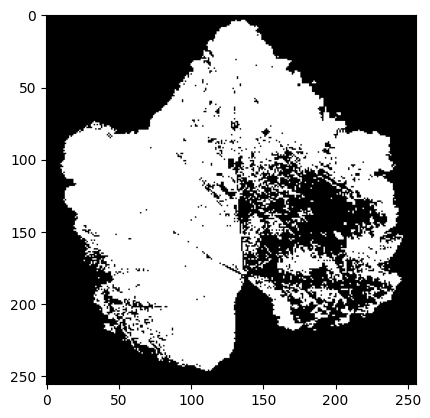

In [8]:
thresh = pcv.threshold.binary(gray_img=gray_img, threshold=115, object_type="light")
pcv.plot_image(thresh)

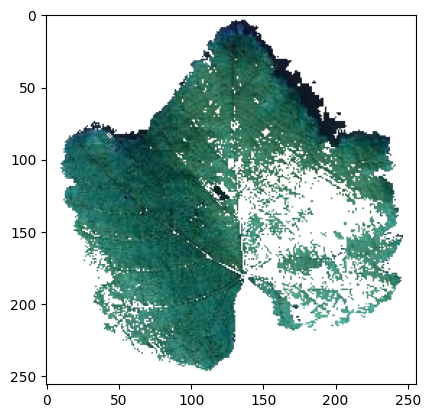

In [9]:
result = np.ones_like(img) * 255
result[thresh == 255] = img[thresh == 255]
mask_img = result
pcv.plot_image(result)

In [10]:
gray_img = pcv.rgb2gray_lab(rgb_img=img, channel='a')
thresh2 = pcv.threshold.triangle(gray_img=gray_img, object_type="dark", xstep= 100)
edge_ok = pcv.fill(bin_img=thresh2, size=5000)
pcv.params.debug = "None"
mask = pcv.fill(bin_img=pcv.invert(gray_img=edge_ok), size=1000)

In [11]:
contours_img = np.ones_like(img) * 255
mask_with_no_buffer = mask.copy()
mask_with_buffer = mask.copy()
contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(mask_with_buffer, contours[np.argmax([len(c) for c in contours])], -1, (0, 0, 0), 15)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [12]:
result = np.ones_like(img) * 255
result[thresh == 255] = img[thresh == 255]
green = np.ones_like(result) * 255

green[mask_with_no_buffer == 255] = img[mask_with_no_buffer == 255]
green[thresh == 255] = img[thresh == 255]
green[thresh == 0] = [93, 255, 51]
green[mask_with_no_buffer == 255] = img[mask_with_no_buffer == 255]

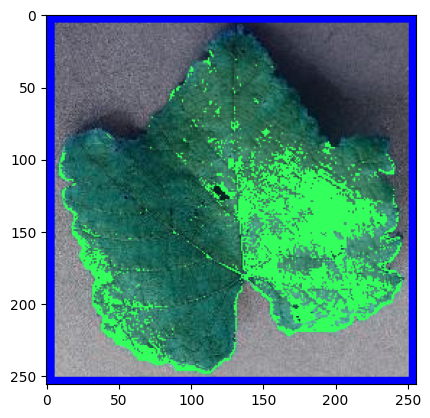

In [13]:

x, y, h, w = 0, 0, 256, 256
roi = green[y:y+h, x:x+w]
cv2.rectangle(green, (x, y), (x+w, y+h), (255, 0, 0),10)
pcv.plot_image(green)

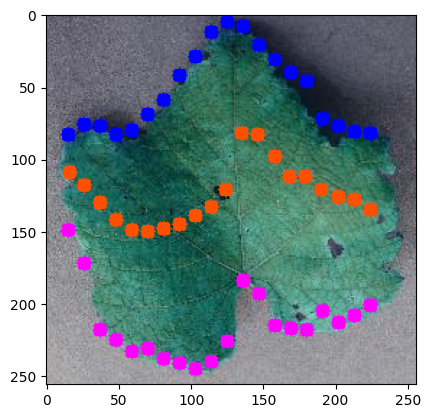

In [14]:
pcv.params.debug = "plot"

top, bottom, center_v = pcv.homology.x_axis_pseudolandmarks(img=img, mask=thresh)